# Mean-Variance Optimization

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('multi_asset_etf_data.xlsx')
df

SyntaxError: unmatched ')' (3948112694.py, line 6)

In [30]:
prices = pd.read_excel('multi_asset_etf_data.xlsx', sheet_name='prices')
r = pd.read_excel('multi_asset_etf_data.xlsx', sheet_name='total returns')
xr = pd.read_excel('multi_asset_etf_data.xlsx', sheet_name='excess returns')
xr.set_index('Date', inplace=True)

In [33]:
prices = prices.drop('QAI', axis=1)
r = r.drop('QAI', axis=1)
xr = xr.drop('QAI', axis=1)

1. Summary Statistics
- Calculate and display the mean and volatility of each asset's excess return
- Calculate Sharpe Ratio
- Annualize all three stats

In [38]:
mean_xr = xr.mean() * 12
vol = xr.std() * np.sqrt(12)
sharpe = mean_xr / vol
combined = pd.concat([mean_xr, vol, sharpe], axis=1)
combined = combined.rename(columns={0:"Annualized Excess Return Mean", 1:"Annualized Excess Return Volatility", 2: "Annualized Sharpe Ratio"})
combined

,Annualized Excess Return Mean,Annualized Excess Return Volatility,Annualized Sharpe Ratio
BWX,-0.007716,0.082789,-0.093202
DBC,-0.005292,0.166553,-0.031774
EEM,0.029339,0.176164,0.166542
EFA,0.061775,0.150903,0.409372
HYG,0.041371,0.075928,0.544873
IEF,0.016404,0.063442,0.258569
IYR,0.074916,0.168675,0.444143
PSP,0.092561,0.213370,0.433804
SPY,0.128141,0.142839,0.897103
TIP,0.020502,0.051115,0.401091


SPY has the best Sharpe Ratio with a value of 0.897 and BWX has the worst Sharpe Ratio with a value of -0.093. 

2. Decriptive Analysis
- Calculate Correlation Matrix of the Returns --> find which pair has the highest and lowest
- How well have TIPS done in our sample?

In [52]:
corr_mat = xr.corr()
corr_mat

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,SPY,TIP
BWX,1.000000,0.191116,0.621673,0.602820,0.602555,0.580891,0.552557,0.526692,0.439994,0.675151
DBC,0.191116,1.000000,0.511667,0.500922,0.461887,-0.300207,0.280518,0.453303,0.432162,0.109006
EEM,0.621673,0.511667,1.000000,0.819925,0.691167,0.026704,0.584063,0.750109,0.687751,0.378792
EFA,0.602820,0.500922,0.819925,1.000000,0.787191,0.042639,0.699292,0.895320,0.845863,0.394821
HYG,0.602555,0.461887,0.691167,0.787191,1.000000,0.187258,0.739356,0.812157,0.793518,0.538648
IEF,0.580891,-0.300207,0.026704,0.042639,0.187258,1.000000,0.316532,0.022436,0.000815,0.754102
IYR,0.552557,0.280518,0.584063,0.699292,0.739356,0.316532,1.000000,0.749836,0.754711,0.598742
PSP,0.526692,0.453303,0.750109,0.895320,0.812157,0.022436,0.749836,1.000000,0.891687,0.408005
SPY,0.439994,0.432162,0.687751,0.845863,0.793518,0.000815,0.754711,0.891687,1.000000,0.381625
TIP,0.675151,0.109006,0.378792,0.394821,0.538648,0.754102,0.598742,0.408005,0.381625,1.000000


In [88]:
filtered_mat = corr_mat.copy()
np.fill_diagonal(filtered_mat.values, np.nan)

max_value = filtered_mat.stack().max()
high_row, high_col = filtered_mat.stack().idxmax()

min_value = filtered_mat.stack().min()
low_row, low_col = filtered_mat.stack().idxmin()

print("Max corellation of", max_value, "between ", high_row, " and ", high_col)
print("Mix corellation of", min_value, "between ", low_row, " and ", low_col)

Max corellation of 0.8953201243752301 between  EFA  and  PSP
Mix corellation of -0.30020714105644963 between  DBC  and  IEF


Text(0.5, 1.0, 'Correlation Heatmap of Excess Returns')

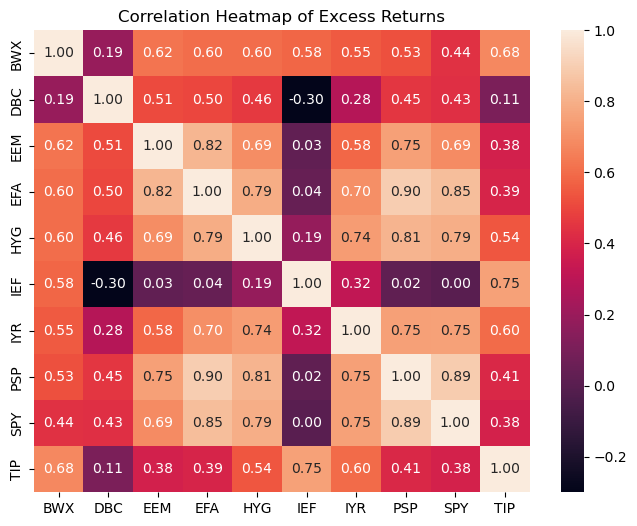

In [91]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_mat, annot=True, fmt='.2f')
plt.title('Correlation Heatmap of Excess Returns')

3. MV Frontier
- Compute and display the weights of the tangency portfolios: w tan
- Compute the mean, volatility, and Sharpe Ratio for the tangency portfolio

In [122]:
SIGMA = xr.cov().values
delta_tan = 1 / (np.ones(10).T @ np.linalg.inv(SIGMA) @ mean_xr.values)
w_tan = delta_tan * (np.linalg.inv(SIGMA) @ mean_xr.values)
w_vec = pd.DataFrame(w_tan, index=combined.index, columns=['Weights'])
w_vec

,Weights
BWX,-0.850643
DBC,-0.071623
EEM,0.026437
EFA,0.068682
HYG,0.290614
IEF,0.881186
IYR,-0.246582
PSP,-0.332995
SPY,1.059632
TIP,0.175293


In [170]:
w_port_ret = xr.values @ w_tan
w_mean_ret = w_port_ret.mean() * 12
port_vol = w_port_ret.std() * np.sqrt(12)
port_sharpe = w_mean_ret / port_vol
tan_performance = pd.DataFrame({'Mean Return': [w_mean_ret], 'Vol': [port_vol], 'Sharpe': [port_sharpe]})
display(tan_performance)

mean_portfolio_ret = w_tan.T @ mean_xr.values
mean_portfolio_ret

,Mean Return,Vol,Sharpe
0,0.12852,0.087222,1.47348


0.1285204969860562

4. TIPS\
Assess how much the tangency portfolio (and performance) change if:
- TIPS are dropped completely from the investment set
- The expected excess return to TIPS is adjusted to be 0.0012 higher than what the historic sample shows.

In [150]:
# Dropped
no_tips = xr.drop('TIP', axis=1)
SIGMA_nt = no_tips.cov().values
mu = no_tips.mean() * 12

delta_tan = 1 / (np.ones(9).T @ np.linalg.inv(SIGMA_nt) @ mu.values)
w_no_tips = delta_tan * (np.linalg.inv(SIGMA_nt) @ mu.values)
w_vec_no_tips = pd.DataFrame(w_no_tips, index=mu.index, columns=['Weights (No TIPS)'])

display(w_vec, w_vec_no_tips)

,Weights
BWX,-0.850643
DBC,-0.071623
EEM,0.026437
EFA,0.068682
HYG,0.290614
IEF,0.881186
IYR,-0.246582
PSP,-0.332995
SPY,1.059632
TIP,0.175293


,Weights (No TIPS)
BWX,-0.879292
DBC,-0.063742
EEM,0.032493
EFA,0.060153
HYG,0.316300
IEF,1.019957
IYR,-0.247445
PSP,-0.339398
SPY,1.100973


In [171]:
no_tips_port_ret = no_tips.values @ w_no_tips
no_tips_mean_ret = no_tips_port_ret.mean() * 12
no_tips_port_vol = no_tips_port_ret.std() * np.sqrt(12)
no_tips_port_sharpe = no_tips_mean_ret / no_tips_port_vol
display(pd.DataFrame({'Mean Return': [no_tips_mean_ret], 'Vol': [no_tips_port_vol], 'Sharpe': [no_tips_port_sharpe]}))

,Mean Return,Vol,Sharpe
0,0.132736,0.090189,1.471758


In [169]:
# E[excess return] increases by .0012
xr_inc = xr.copy()
xr_inc['TIP'] = xr_inc['TIP'] + 0.0012
SIGMA_ = xr_inc.cov().values
mu_inc = xr_inc.mean() * 12

delta_tan = 1 / (np.ones(10).T @ np.linalg.inv(SIGMA_) @ mu_inc.values)
w_inc = delta_tan * (np.linalg.inv(SIGMA_) @ mu_inc.values)
w_vec_inc = pd.DataFrame(w_inc, index=mu_inc.index, columns=['Weights (Increased TIPS)'])

display(w_vec_inc)

,Weights (Increased TIPS)
BWX,-0.669693
DBC,-0.121397
EEM,-0.011815
EFA,0.122554
HYG,0.128372
IEF,0.004667
IYR,-0.241132
PSP,-0.292555
SPY,0.798513
TIP,1.282487


In [178]:
tips_inc_port_ret = xr_inc.values @ w_inc
tips_inc_mean_ret = tips_inc_port_ret.mean() * 12
tips_inc_port_vol = tips_inc_port_ret.std() * np.sqrt(12)
tips_inc_port_sharpe = tips_inc_mean_ret / tips_inc_port_vol
display(pd.DataFrame({'Mean Return': [tips_inc_mean_ret], 'Vol': [tips_inc_port_vol], 'Sharpe': [tips_inc_port_sharpe]}))

,Mean Return,Vol,Sharpe
0,0.120361,0.07443,1.617104


# Allocations
investor now has a targeted mean excess return (per month) of 0.01

1. Equally - weighted (EW)\
Rescale the entire weighting vector to have target mean

In [164]:
w_ew = np.ones(10) / 10
delta_ew = 0.01 / (xr.mean() @ w_ew)
w_ew = delta_ew * w_ew
w_ew

w_ew_ret = xr.values @ w_ew
w_ew_mean_ret = w_ew_ret.mean() * 12
ew_vol = w_ew_ret.std() * np.sqrt(12)
ew_sharpe = w_ew_mean_ret / ew_vol
ew_performance = pd.DataFrame({'Mean Return': [w_ew_mean_ret], 'Vol': [ew_vol], 'Sharpe': [ew_sharpe]})

2. Risk - parity

In [163]:
w_rp = np.array(1 / np.sqrt(np.diag(xr.cov())))
delta_rp = 0.01 / (xr.mean() @ w_rp)
w_rp = delta_rp * w_rp

w_rp_ret = xr.values @ w_rp
w_rp_mean_ret = w_rp_ret.mean() * 12
rp_vol = w_rp_ret.std() * np.sqrt(12)
rp_sharpe = w_rp_mean_ret / rp_vol
rp_performance = pd.DataFrame({'Mean Return': [w_rp_mean_ret], 'Vol': [rp_vol], 'Sharpe': [rp_sharpe]})

3. Mean Variance (MV)

Compare the allocation methods
- rescale each weight vector, such that it has targeted mean return of 0.01

In [162]:
delta_target = 0.01 / (xr.mean() @ w_tan)
w_target = delta_target * w_tan

w_target_ret = xr.values @ w_target
w_target_mean_ret = w_target_ret.mean() * 12
target_vol = w_target_ret.std() * np.sqrt(12)
target_sharpe = w_target_mean_ret / target_vol
target_performance = pd.DataFrame({'Mean Return': [w_target_mean_ret], 'Vol': [target_vol], 'Sharpe': [target_sharpe]})

In [165]:
weights = pd.DataFrame({"Equally-Weighted":w_ew, "Risk-Parity": w_rp, "Tangency": w_tan, "Target":w_target}, index=combined.index)
weights

,Equally-Weighted,Risk-Parity,Tangency,Target
BWX,0.265486,0.422521,-0.850643,-0.794248
DBC,0.265486,0.210024,-0.071623,-0.066874
EEM,0.265486,0.198565,0.026437,0.024684
EFA,0.265486,0.231805,0.068682,0.064129
HYG,0.265486,0.460702,0.290614,0.271347
IEF,0.265486,0.551374,0.881186,0.822766
IYR,0.265486,0.207381,-0.246582,-0.230235
PSP,0.265486,0.163941,-0.332995,-0.310919
SPY,0.265486,0.244892,1.059632,0.989382
TIP,0.265486,0.684338,0.175293,0.163671


In [177]:
performance = pd.concat([ew_performance, rp_performance, tan_performance, target_performance], axis=0)
performance = performance.set_index(np.array(["EW Portfolio", "RP Portfolio", "Tangent Portfolio", "Target Portfolio"]))
performance

,Mean Return,Vol,Sharpe
EW Portfolio,0.12000,0.268464,0.446988
RP Portfolio,0.12000,0.260052,0.461447
Tangent Portfolio,0.12852,0.087222,1.473480
Target Portfolio,0.12000,0.081440,1.473480
